### imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
import time
from sklearn.metrics import confusion_matrix

read the data

In [2]:
columns = ['user_id','item_id','rating','timestamp']
df = pd.read_csv('u.data.txt', sep='\t', names=columns)
df

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742
...,...,...,...,...
99998,880,476,3,880175444
99999,716,204,5,879795543
100000,276,1090,1,874795795
100001,13,225,2,882399156


<hr>
distribution of average movie rating and number of ratings per movie

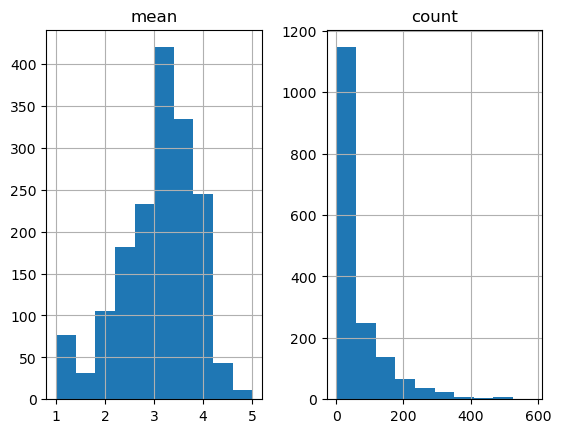

In [3]:
df.groupby('item_id')['rating'].agg(['mean','count']).hist()
plt.show()

### create a user-item matrix where the values are the ratings

In [5]:
pivot = pd.pivot(df,index='item_id',columns='user_id',values='rating').fillna(0)

In [6]:
# remove items with less than 20 ratings
pivot = pivot.loc[pivot.sum(axis=1)>=20]

use PCA to reduce dimensionality to just 2 dimensions

In [11]:
model = PCA(n_components=2).fit(pivot)

In [13]:
pred = model.transform(pivot)
explained_var = model.explained_variance_ / model.explained_variance_.sum()
print(explained_var)

[0.79283407 0.20716593]


ploting the 2 dimensions

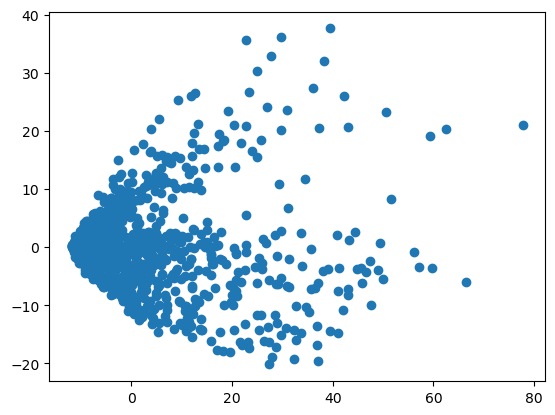

In [14]:
plt.scatter(pred[:,0],pred[:,1])
plt.show()

## collaborative filtering movie recommendation using correlation

let's take movie 181 as an example. calculate the correlation between movie 181 and all other movies

In [16]:
index = 181
corrs = pivot.T.corrwith(pivot.T[index])

sort the correlations in descending order 

In [114]:
corrs.sort_values(ascending=False).drop(index)

item_id
50     0.746797
172    0.548797
174    0.503323
210    0.478037
121    0.455964
         ...   
306   -0.118851
302   -0.125226
303   -0.144714
340   -0.159143
286   -0.181992
Length: 1234, dtype: float64

now we can take the top 5 movies as recommendations. Any user who liked movie 181 can be recommended the following movies:
50,172,174,210,121

### Let's try to create a simple logistic regression to predict whether a certain user would like a specific movie.

here, we will change the ratings to binary. 1 if rated and 0 if not rated.

In [17]:
pivot_bin = (pivot>0).astype(int)

we want to try to predict a movie which is rated a lot of times so that we'll have a lot of samples with 1's and a lot of samples with 0's thus creating a balanced dataset with many training samples. to do this, we'll choose the most rated movie

In [18]:
#most rated movie
pivot_bin.sum(axis=1).sort_values(ascending=False).iloc[[0]]

item_id
50    584
dtype: int64

movie id: 50  
users who watched it: 584

In [19]:
pivot_bin.shape[1]

944

total number of users: 944  

as a baseline model we can predict that everyone watched it and we would be correct 584/994 times (59% of the time)

In [20]:
# LogisticRegression
x = pivot_bin.T.drop(50,axis=1).values
y = pivot_bin.T[[50]].values.ravel()
x.shape, y.shape

((944, 1234), (944,))

split data into train and test

In [23]:
train_len = int(len(x)*0.7)

x_train = x[:train_len]
y_train = y[:train_len]
x_test = x[train_len:]
y_test = y[train_len:]

build and fit the logistic regression model

In [22]:
model = LogisticRegression()
model.fit(x_train,y_train)
pred = model.predict(x_test)

In [198]:
(pred == y_test).mean()

0.8591549295774648

In [199]:
confusion_matrix(y_test,pred)

array([[ 91,  21],
       [ 19, 153]], dtype=int64)

we received an accuracy of 86%, which is much higher than the baseline model accuracy (59%)  

this is a very good method for prediction, especially if we use more complicated models such as neural networks, random forest, or XGBoost. However, this method is somewhat computationally expensive as we would need to fit a model for every single possible movie. Also, it will be less effective for movies that have not been rated many times.

# other possible methods for recommendation

- we did collaborative filtering based on movie-to-movie similarity. similar methods can be done for user-to-user similarity
- content-based filtering
- PCA for dimensionality reduction, then similarity calculation (either euclidean, cosine, jaccard, or correlation)
- for business problems where it's expected that the order matters, we can use an RNN to predict the next movie someone will watch based on the past n number of movies they watched
- recommendation just based on ratings. To factor in that some less ranked movies may have high ratings which are statistically significant, we can calculate a confidence interval and take the lower value. let's say we decide to always take 2 standard deviations below mean. 
   - e.g: a movie has 50 ratings with an average rating of 3.8 and a standard devation of 0.5. then: -2 = miu-3.8 / (0.5 / sqrt(50)) ==> miu = 3.66
   - e.g: a movie has 10 ratings with an average rating as 3.8 and a standard devation of 0.5. then: -2 = miu-3.8 / (0.5 / sqrt(10)) ==> miu = 3.48